# Neural ODE

In [6]:
import math
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torchdiffeq import odeint_adjoint as odeint
import matplotlib.pyplot as plt

## Time invariant dynamic

In [11]:
def make_spiral_dataset(n_traj=512, n_points=50, t_max=5.0, noise_std=0.02, device="cpu"):
    t = torch.linspace(0.0, t_max, n_points, device=device)  # (T,)

    # Column-vector convention: x' = A x produces a spiral (same as torchdiffeq spiral demo up to transpose) :contentReference[oaicite:2]{index=2}
    A = torch.tensor([[-0.1, -1.0],
                      [ 1.0, -0.1]], device=device)

    # Random initial conditions on a ring
    angles = 2 * math.pi * torch.rand(n_traj, device=device)
    radii  = 0.5 + 1.5 * torch.rand(n_traj, device=device)
    x0 = torch.stack([radii * torch.cos(angles), radii * torch.sin(angles)], dim=1)  # (N,2)

    # Closed-form: x(t)=exp(A t)x0
    y = torch.empty(n_traj, n_points, 2, device=device)
    for k, tk in enumerate(t):
        expAtk = torch.linalg.matrix_exp(A * tk)             # (2,2)
        y[:, k, :] = x0 @ expAtk.T                           # (N,2)

    if noise_std > 0:
        y = y + noise_std * torch.randn_like(y)

    return t, y

In [12]:
class ODEFunc(nn.Module):
    def __init__(self, hidden=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, hidden),
            nn.Tanh(),
            nn.Linear(hidden, hidden),
            nn.Tanh(),
            nn.Linear(hidden, 2),
        )
        # (Optional) small init helps some problems
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=0.1)
                nn.init.constant_(m.bias, 0.0)

    def forward(self, t, y):
        return self.net(y)

In [13]:
def train(device="cpu"):
    torch.manual_seed(0)

    t, y = make_spiral_dataset(n_traj=1024, n_points=50, t_max=5.0, noise_std=0.02, device=device)
    y0 = y[:, 0, :]                 # (N,2)
    y_target = y                    # (N,T,2)

    ds = TensorDataset(y0, y_target)
    dl = DataLoader(ds, batch_size=256, shuffle=True)

    func = ODEFunc(hidden=64).to(device)
    opt = torch.optim.Adam(func.parameters(), lr=1e-3)

    for epoch in range(1, 201):
        running = 0.0
        for batch_y0, batch_y in dl:
            # odeint returns (T,B,2) when y0 is (B,2) :contentReference[oaicite:3]{index=3}
            pred = odeint(func, batch_y0, t, rtol=1e-6, atol=1e-6)  # (T,B,2)
            pred = pred.permute(1, 0, 2).contiguous()              # (B,T,2)

            loss = torch.mean((pred - batch_y) ** 2)

            opt.zero_grad(set_to_none=True)
            loss.backward()
            opt.step()

            running += loss.item() * batch_y0.size(0)

        if epoch % 20 == 0:
            print(f"epoch {epoch:03d} | mse {running/len(ds):.6f}")

    return func, t

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
func, t = train(device=device)

cuda
epoch 020 | mse 0.250663
epoch 040 | mse 0.001940
epoch 060 | mse 0.001823
epoch 080 | mse 0.001761
epoch 100 | mse 0.001698
epoch 120 | mse 0.001636
epoch 140 | mse 0.001577
epoch 160 | mse 0.001522
epoch 180 | mse 0.001478
epoch 200 | mse 0.001423


[TEST] traj MSE: 1.540947e-03
[TEST] dyn  MSE: 1.597002e-04
[TEST] dyn  cosine(sim): 0.999995


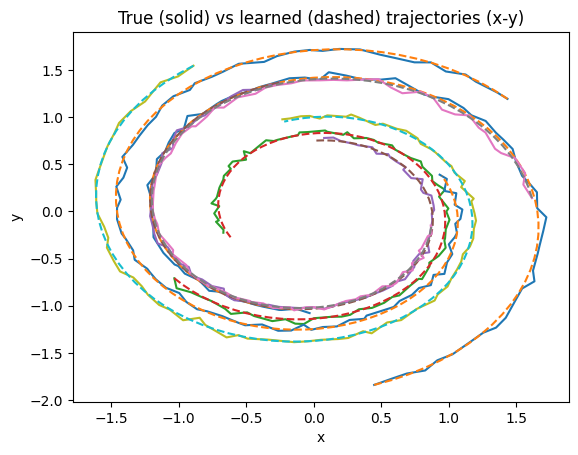

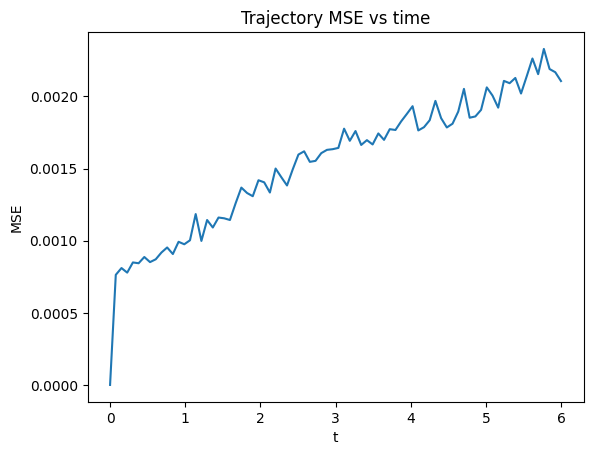

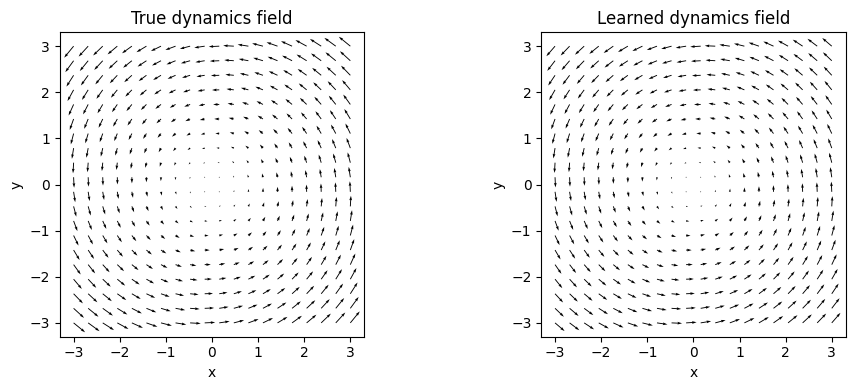

In [15]:
# True dynamics used to generate the dataset (must match make_spiral_dataset)
A_TRUE = torch.tensor([[-0.1, -1.0],
                       [ 1.0, -0.1]])

def true_f(y, device=None):
    # y: (B,2) -> dy: (B,2) for x' = A x
    A = A_TRUE.to(y.device if device is None else device)
    return y @ A.T

@torch.no_grad()
def eval_and_plot(func, odeint, device="cpu", n_test=256, n_points=80, t_max=6.0, noise_std=0.02):
    # ---- test data
    t_test, y_test = make_spiral_dataset(
        n_traj=n_test, n_points=n_points, t_max=t_max, noise_std=noise_std, device=device
    )
    y0_test = y_test[:, 0, :]                    # (N,2)

    # ---- learned trajectories
    y_pred = odeint(func, y0_test, t_test, rtol=1e-6, atol=1e-6)  # (T,N,2)
    y_pred = y_pred.permute(1, 0, 2).contiguous()                 # (N,T,2)

    # ---- trajectory metrics
    traj_mse = torch.mean((y_pred - y_test) ** 2).item()
    traj_mse_per_t = torch.mean((y_pred - y_test) ** 2, dim=(0, 2)).cpu()  # (T,)

    # ---- dynamics metrics evaluated on TRUE states
    # dy_true(t_i) = A z(t_i)
    dy_true = true_f(y_test.reshape(-1, 2)).reshape(n_test, n_points, 2)

    # dy_hat(t_i) = f_theta(z(t_i), t_i)
    dy_hat_list = []
    for k in range(n_points):
        dy_hat_list.append(func(t_test[k], y_test[:, k, :]))  # (N,2)
    dy_hat = torch.stack(dy_hat_list, dim=1)  # (N,T,2)

    dyn_mse = torch.mean((dy_hat - dy_true) ** 2).item()

    # cosine similarity of dynamics (1 is perfect direction match)
    eps = 1e-12
    dot = torch.sum(dy_hat * dy_true, dim=-1)
    n1 = torch.linalg.norm(dy_hat, dim=-1)
    n2 = torch.linalg.norm(dy_true, dim=-1)
    dyn_cos = torch.mean(dot / (n1 * n2 + eps)).item()

    print(f"[TEST] traj MSE: {traj_mse:.6e}")
    print(f"[TEST] dyn  MSE: {dyn_mse:.6e}")
    print(f"[TEST] dyn  cosine(sim): {dyn_cos:.6f}")

    # ---- plots: (A) trajectories overlay for a few samples
    idx = torch.linspace(0, n_test - 1, steps=6).long()
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111)
    for i in idx:
        yt = y_test[i].cpu()
        yp = y_pred[i].cpu()
        ax1.plot(yt[:, 0], yt[:, 1])  # true
        ax1.plot(yp[:, 0], yp[:, 1], linestyle="--")  # pred
    ax1.set_title("True (solid) vs learned (dashed) trajectories (x-y)")
    ax1.set_xlabel("x"); ax1.set_ylabel("y")

    # ---- plots: (B) error over time
    fig2 = plt.figure()
    ax2 = fig2.add_subplot(111)
    ax2.plot(t_test.cpu(), traj_mse_per_t)
    ax2.set_title("Trajectory MSE vs time")
    ax2.set_xlabel("t"); ax2.set_ylabel("MSE")

    # ---- plots: (C) vector field comparison on a grid
    grid_n = 20
    lim = 3.0
    xs = torch.linspace(-lim, lim, grid_n)
    ys = torch.linspace(-lim, lim, grid_n)
    X, Y = torch.meshgrid(xs, ys, indexing="xy")
    P = torch.stack([X.reshape(-1), Y.reshape(-1)], dim=1).to(device)

    ft = true_f(P).cpu()
    fh = func(t_test[0], P).cpu()  # autonomous net: any t is fine here

    fig3 = plt.figure(figsize=(10, 4))
    ax3a = fig3.add_subplot(1, 2, 1)
    ax3b = fig3.add_subplot(1, 2, 2)

    ax3a.quiver(P[:, 0].cpu(), P[:, 1].cpu(), ft[:, 0], ft[:, 1])
    ax3a.set_title("True dynamics field")
    ax3a.set_xlabel("x"); ax3a.set_ylabel("y"); ax3a.set_aspect("equal", "box")

    ax3b.quiver(P[:, 0].cpu(), P[:, 1].cpu(), fh[:, 0], fh[:, 1])
    ax3b.set_title("Learned dynamics field")
    ax3b.set_xlabel("x"); ax3b.set_ylabel("y"); ax3b.set_aspect("equal", "box")

    plt.tight_layout()
    plt.show()


eval_and_plot(func, odeint, device=device)

## Time dependant dynamic

In [16]:
# ============================================================
# 1) Time-dependent "true" dynamics + dataset (RK4 ground-truth)
#    x' = A(t) x with time-varying rotation speed omega(t)
# ============================================================

def omega(t):
    # t: scalar tensor
    return 1.0 + 0.5 * torch.sin(1.5 * t)

def true_f(t, y, alpha=0.1):
    # y: (B,2)  (row-vector convention)
    w = omega(t)
    A = torch.stack([
        torch.stack([-torch.tensor(alpha, device=y.device, dtype=y.dtype), -w]),
        torch.stack([ w, -torch.tensor(alpha, device=y.device, dtype=y.dtype)])
    ])  # (2,2)
    return y @ A.T

@torch.no_grad()
def integrate_rk4_batch(y0, t_obs, n_substeps=20, alpha=0.1):
    """
    Fixed-step RK4 integrating from t_obs[0] to t_obs[-1], returning y at observation times.
    y0: (N,2)
    t_obs: (T,)
    returns y: (N,T,2)
    """
    device, dtype = y0.device, y0.dtype
    N = y0.shape[0]
    T = t_obs.numel()
    y = torch.empty(N, T, 2, device=device, dtype=dtype)
    y[:, 0, :] = y0

    for i in range(T - 1):
        t0 = t_obs[i]
        t1 = t_obs[i + 1]
        h = (t1 - t0) / n_substeps
        yi = y[:, i, :]

        t = t0
        for _ in range(n_substeps):
            k1 = true_f(t, yi, alpha=alpha)
            k2 = true_f(t + 0.5 * h, yi + 0.5 * h * k1, alpha=alpha)
            k3 = true_f(t + 0.5 * h, yi + 0.5 * h * k2, alpha=alpha)
            k4 = true_f(t + h, yi + h * k3, alpha=alpha)
            yi = yi + (h / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
            t = t + h

        y[:, i + 1, :] = yi

    return y

def make_time_dependent_dataset(
    n_traj=1024, n_points=50, t_max=6.0, noise_std=0.02, n_substeps=30, device="cpu", dtype=torch.float32
):
    t = torch.linspace(0.0, t_max, n_points, device=device, dtype=dtype)

    # initial conditions on a ring
    angles = 2 * math.pi * torch.rand(n_traj, device=device, dtype=dtype)
    radii  = 0.5 + 1.5 * torch.rand(n_traj, device=device, dtype=dtype)
    y0 = torch.stack([radii * torch.cos(angles), radii * torch.sin(angles)], dim=1)  # (N,2)

    y = integrate_rk4_batch(y0, t, n_substeps=n_substeps)  # (N,T,2)

    if noise_std > 0:
        y = y + noise_std * torch.randn_like(y)

    return t, y  # t: (T,), y: (N,T,2)



In [17]:
# ============================================================
# 2) Neural ODE model (time-dependent net: f(t,y))
# ============================================================

class TimeODEFunc(nn.Module):
    def __init__(self, t_max, hidden=64):
        super().__init__()
        self.t_max = float(t_max)
        self.net = nn.Sequential(
            nn.Linear(3, hidden),
            nn.Tanh(),
            nn.Linear(hidden, hidden),
            nn.Tanh(),
            nn.Linear(hidden, 2),
        )
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=0.1)
                nn.init.constant_(m.bias, 0.0)

    def forward(self, t, y):
        # y: (B,2)
        # normalize time to roughly [-1, 1]
        tn = (t / self.t_max) * 2.0 - 1.0
        tn = tn.expand(y.shape[0], 1)
        inp = torch.cat([y, tn], dim=1)  # (B,3)
        return self.net(inp)

In [18]:
# ============================================================
# 3) Train on non-bidirectional, time-dependent dataset
# ============================================================

def train_time_dependent(device="cpu"):
    torch.manual_seed(0)

    t, y = make_time_dependent_dataset(n_traj=2048, n_points=60, t_max=6.0, noise_std=0.02, device=device)
    y0 = y[:, 0, :]  # (N,2)

    ds = TensorDataset(y0, y)
    dl = DataLoader(ds, batch_size=256, shuffle=True)

    func = TimeODEFunc(t_max=float(t[-1].item()), hidden=64).to(device)
    opt = torch.optim.Adam(func.parameters(), lr=1e-3)

    for epoch in range(1, 201):
        running = 0.0
        for batch_y0, batch_y in dl:
            pred = odeint(func, batch_y0, t, rtol=1e-6, atol=1e-6)  # (T,B,2)
            pred = pred.permute(1, 0, 2).contiguous()               # (B,T,2)

            loss = torch.mean((pred - batch_y) ** 2)
            opt.zero_grad(set_to_none=True)
            loss.backward()
            opt.step()

            running += loss.item() * batch_y0.size(0)

        if epoch % 20 == 0:
            print(f"epoch {epoch:03d} | mse {running/len(ds):.6f}")

    return func

In [19]:
# ============================================================
# 4) Compare learned vs true: trajectories + dynamics (time-dependent)
# ============================================================

@torch.no_grad()
def eval_time_dependent(func, device="cpu", n_test=256, n_points=80, t_max=6.0):
    t, y_true = make_time_dependent_dataset(
        n_traj=n_test, n_points=n_points, t_max=t_max, noise_std=0.0, n_substeps=40, device=device
    )
    y0 = y_true[:, 0, :]

    # trajectory prediction
    y_pred = odeint(func, y0, t, rtol=1e-6, atol=1e-6).permute(1, 0, 2).contiguous()  # (N,T,2)

    traj_mse = torch.mean((y_pred - y_true) ** 2).item()
    traj_mse_per_t = torch.mean((y_pred - y_true) ** 2, dim=(0, 2)).cpu()

    # dynamics comparison on TRUE states: f_theta(t, z_true(t)) vs f_true(t, z_true(t))
    dy_true = torch.empty_like(y_true)
    dy_hat  = torch.empty_like(y_true)
    for k in range(n_points):
        tk = t[k]
        zk = y_true[:, k, :]
        dy_true[:, k, :] = true_f(tk, zk)
        dy_hat[:, k, :]  = func(tk, zk)

    dyn_mse = torch.mean((dy_hat - dy_true) ** 2).item()
    eps = 1e-12
    dot = torch.sum(dy_hat * dy_true, dim=-1)
    n1 = torch.linalg.norm(dy_hat, dim=-1)
    n2 = torch.linalg.norm(dy_true, dim=-1)
    dyn_cos = torch.mean(dot / (n1 * n2 + eps)).item()

    print(f"[TEST] traj MSE: {traj_mse:.6e}")
    print(f"[TEST] dyn  MSE: {dyn_mse:.6e}")
    print(f"[TEST] dyn  cosine(sim): {dyn_cos:.6f}")

    # --- Plot trajectories overlay
    idx = torch.linspace(0, n_test - 1, steps=6).long()
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111)
    for i in idx:
        yt = y_true[i].cpu()
        yp = y_pred[i].cpu()
        ax1.plot(yt[:, 0], yt[:, 1])
        ax1.plot(yp[:, 0], yp[:, 1], linestyle="--")
    ax1.set_title("Time-dependent: true (solid) vs learned (dashed) trajectories")
    ax1.set_xlabel("x"); ax1.set_ylabel("y")

    # --- Plot MSE vs time
    fig2 = plt.figure()
    ax2 = fig2.add_subplot(111)
    ax2.plot(t.cpu(), traj_mse_per_t)
    ax2.set_title("Trajectory MSE vs time")
    ax2.set_xlabel("t"); ax2.set_ylabel("MSE")

    # --- Vector field comparison at multiple time slices
    grid_n, lim = 20, 3.0
    xs = torch.linspace(-lim, lim, grid_n)
    ys = torch.linspace(-lim, lim, grid_n)
    X, Y = torch.meshgrid(xs, ys, indexing="xy")
    P = torch.stack([X.reshape(-1), Y.reshape(-1)], dim=1).to(device)

    time_slices = [0.0, t_max * 0.5, t_max]
    fig3 = plt.figure(figsize=(12, 8))
    for row, ts in enumerate(time_slices, start=1):
        ts = torch.tensor(ts, device=device, dtype=t.dtype)
        ft = true_f(ts, P).cpu()
        fh = func(ts, P).cpu()

        axL = fig3.add_subplot(len(time_slices), 2, 2*row-1)
        axR = fig3.add_subplot(len(time_slices), 2, 2*row)

        axL.quiver(P[:, 0].cpu(), P[:, 1].cpu(), ft[:, 0], ft[:, 1])
        axL.set_title(f"True field at t={float(ts.item()):.2f}")
        axL.set_aspect("equal", "box")

        axR.quiver(P[:, 0].cpu(), P[:, 1].cpu(), fh[:, 0], fh[:, 1])
        axR.set_title(f"Learned field at t={float(ts.item()):.2f}")
        axR.set_aspect("equal", "box")

    plt.tight_layout()
    plt.show()


epoch 020 | mse 0.044813
epoch 040 | mse 0.043229
epoch 060 | mse 0.041874
epoch 080 | mse 0.039206
epoch 100 | mse 0.030794
epoch 120 | mse 0.025236
epoch 140 | mse 0.023169
epoch 160 | mse 0.021504
epoch 180 | mse 0.020006
epoch 200 | mse 0.018618
[TEST] traj MSE: 1.969702e-02
[TEST] dyn  MSE: 5.736905e-02
[TEST] dyn  cosine(sim): 0.998957


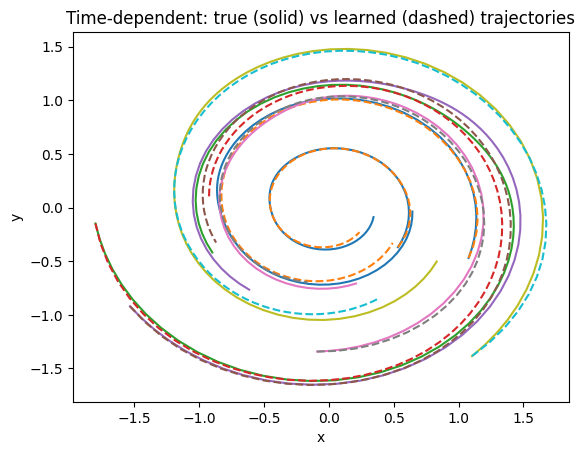

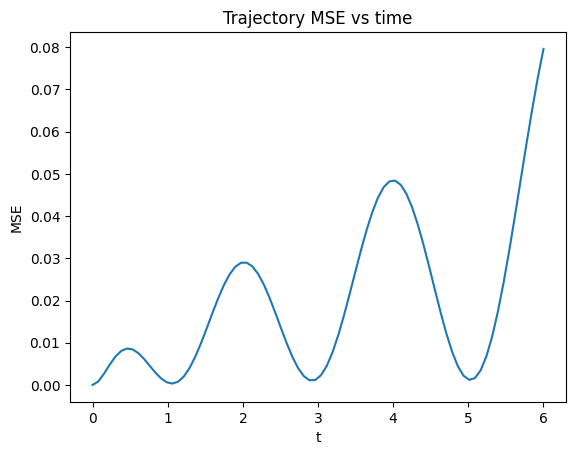

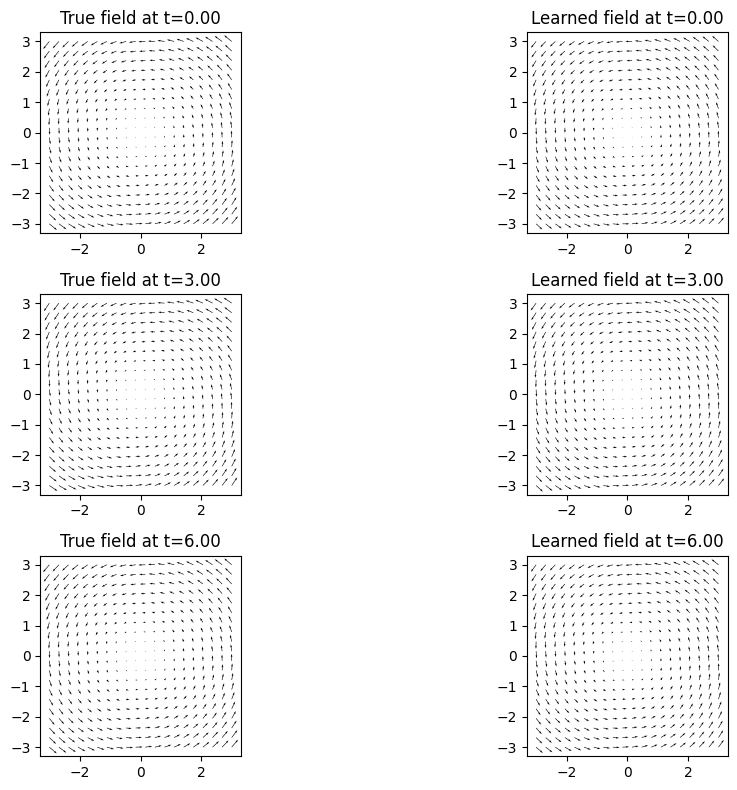

In [20]:
device = "cuda" if torch.cuda.is_available() else "cpu"
func = train_time_dependent(device=device)
eval_time_dependent(func, device=device, n_test=256, n_points=80, t_max=6.0)

In [ ]:
class TimeODEFunc(nn.Module):
    def __init__(self, t_max, hidden=64, n_freqs=8):
        super().__init__()
        self.t_max = float(t_max)
        self.freqs = nn.Parameter(
            torch.linspace(0.1, 10.0, n_freqs), 
            requires_grad=False
        )
        # Input size: 2 (y) + 2*n_freqs (sin/cos embeddings)
        self.net = nn.Sequential(
            nn.Linear(2 + 2*n_freqs, hidden),
            nn.Tanh(),
            nn.Linear(hidden, hidden),
            nn.Tanh(),
            nn.Linear(hidden, 2),
        )
    
    def forward(self, t, y):
        # Create sinusoidal time embeddings
        t_scaled = t / self.t_max * 2 * math.pi
        t_embed = torch.cat([
            torch.sin(self.freqs * t_scaled),
            torch.cos(self.freqs * t_scaled)
        ]).expand(y.shape[0], -1)
        
        inp = torch.cat([y, t_embed], dim=1)
        return self.net(inp)

# ============================================================
# 3) Train on non-bidirectional, time-dependent dataset
# ============================================================

def train_time_dependent(device="cpu"):
    torch.manual_seed(0)

    t, y = make_time_dependent_dataset(n_traj=2048, n_points=60, t_max=6.0, noise_std=0.02, device=device)
    y0 = y[:, 0, :]  # (N,2)

    ds = TensorDataset(y0, y)
    dl = DataLoader(ds, batch_size=256, shuffle=True)

    func = TimeODEFunc(t_max=float(t[-1].item()), hidden=64).to(device)
    opt = torch.optim.Adam(func.parameters(), lr=1e-3)

    for epoch in range(1, 201):
        running = 0.0
        for batch_y0, batch_y in dl:
            pred = odeint(func, batch_y0, t, rtol=1e-6, atol=1e-6)  # (T,B,2)
            pred = pred.permute(1, 0, 2).contiguous()               # (B,T,2)

            loss = torch.mean((pred - batch_y) ** 2)
            opt.zero_grad(set_to_none=True)
            loss.backward()
            opt.step()

            running += loss.item() * batch_y0.size(0)

        if epoch % 20 == 0:
            print(f"epoch {epoch:03d} | mse {running/len(ds):.6f}")

    return func

    

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
func = train_time_dependent(device=device)
eval_time_dependent(func, device=device, n_test=256, n_points=80, t_max=6.0)

## Galerkin Neural ODE

In [25]:
from data_burgers import create_burgers_hermite_time_dataset, BurgersInitialConditions

ds = create_burgers_hermite_time_dataset(
    initial_condition=BurgersInitialConditions.gaussian(),
    Tmax=2.0,
    n_basis=48,
    n_time_samples=400,
    t_sampling="random",
    device="cuda",
    normalize_c=True,
)

t, c = ds.get_trajectory()  # t: (nT,), c: (nT,K)
sample = ds[0]              # {'t': (1,), 'c': (K,)}


Computing exact Burgers soluton...: 41it [00:06,  6.58it/s]


In [26]:
# neural_ode_hermite_burgers.py
import torch
import torch.nn as nn
from torchdiffeq import odeint_adjoint as odeint  # pip install torchdiffeq

# ------------------------------------------------------------
# Neural ODE for coefficient dynamics:  c'(t) = f_theta(t, c)
# ------------------------------------------------------------
class CoeffODEFunc(nn.Module):
    def __init__(self, K: int, hidden: int = 256, time_dependent: bool = False):
        super().__init__()
        self.time_dependent = time_dependent
        inp = K + (1 if time_dependent else 0)
        self.net = nn.Sequential(
            nn.Linear(inp, hidden),
            nn.Tanh(),
            nn.Linear(hidden, hidden),
            nn.Tanh(),
            nn.Linear(hidden, K),
        )
        # small output init helps stability
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=0.5)
                nn.init.zeros_(m.bias)

    def forward(self, t, c):
        # c: (B,K)
        if self.time_dependent:
            tt = t.expand(c.shape[0], 1)
            x = torch.cat([c, tt], dim=1)
        else:
            x = c
        return self.net(x)  # (B,K)


def train_neural_ode_on_trajectory(
    t: torch.Tensor,          # (nT,)
    c: torch.Tensor,          # (nT,K)
    epochs: int = 2000,
    lr: float = 1e-3,
    hidden: int = 256,
    time_dependent: bool = False,
    method: str = "rk4",
    steps: int = 8,           # for rk4 fixed-step
    rtol: float = 1e-6,
    atol: float = 1e-6,
    print_every: int = 100,
):
    device = c.device
    nT, K = c.shape

    func = CoeffODEFunc(K, hidden=hidden, time_dependent=time_dependent).to(device)
    opt = torch.optim.Adam(func.parameters(), lr=lr)

    # initial condition = first sample
    c0 = c[0].unsqueeze(0)  # (1,K)

    # Use dataset time stamps directly (already sorted by dataset)
    t_ode = t.clone()

    for ep in range(1, epochs + 1):
        # integrate
        if method == "rk4":
            c_pred = odeint(func, c0, t_ode, method="rk4", options={"step_size": float((t_ode[-1]-t_ode[0])/(len(t_ode)-1))/steps})
        else:
            c_pred = odeint(func, c0, t_ode, rtol=rtol, atol=atol, method=method)

        c_pred = c_pred.squeeze(1)  # (nT,K)

        loss = torch.mean((c_pred - c) ** 2)

        opt.zero_grad(set_to_none=True)
        loss.backward()
        nn.utils.clip_grad_norm_(func.parameters(), 1.0)
        opt.step()

        if ep % print_every == 0 or ep == 1:
            with torch.no_grad():
                # one-step MSE as a sanity metric
                one_step = torch.mean((c_pred[1:] - c[1:]) ** 2).item()
            print(f"epoch {ep:5d} | mse_traj={loss.item():.6e} | mse_no_ic={one_step:.6e}")

    return func


@torch.no_grad()
def rollout(func: nn.Module, t: torch.Tensor, c0: torch.Tensor, method: str = "dopri5"):
    # c0: (K,) or (1,K)
    if c0.ndim == 1:
        c0 = c0.unsqueeze(0)
    c_pred = odeint(func, c0, t, method=method)
    return c_pred.squeeze(1)  # (nT,K)


t, c = ds.get_trajectory()  # t: (nT,), c: (nT,K)

# Ensure shapes and dtypes are ODE-friendly
t = t.to(dtype=torch.float32)
c = c.to(dtype=torch.float32)

# Train
func = train_neural_ode_on_trajectory(
    t=t,
    c=c,
    epochs=2000,
    lr=1e-3,
    hidden=256,
    time_dependent=False,  # Burgers semi-discrete coeff dynamics is typically autonomous
    method="dopri5",       # or "rk4"
    print_every=100,
)

# Rollout / compare
c_pred = rollout(func, t, c0=c[0], method="dopri5")  # (nT,K)
mse = torch.mean((c_pred - c) ** 2).item()
print("final trajectory MSE:", mse)


epoch     1 | mse_traj=1.618184e+01 | mse_no_ic=1.622240e+01
epoch   100 | mse_traj=5.369956e-01 | mse_no_ic=5.383414e-01
epoch   200 | mse_traj=2.487520e-01 | mse_no_ic=2.493754e-01
epoch   300 | mse_traj=1.517948e-01 | mse_no_ic=1.521752e-01
epoch   400 | mse_traj=1.022226e-01 | mse_no_ic=1.024788e-01
epoch   500 | mse_traj=7.151919e-02 | mse_no_ic=7.169843e-02
epoch   600 | mse_traj=5.150330e-02 | mse_no_ic=5.163238e-02
epoch   700 | mse_traj=3.842492e-02 | mse_no_ic=3.852122e-02
epoch   800 | mse_traj=2.975680e-02 | mse_no_ic=2.983138e-02
epoch   900 | mse_traj=2.373919e-02 | mse_no_ic=2.379868e-02
epoch  1000 | mse_traj=1.935716e-02 | mse_no_ic=1.940568e-02
epoch  1100 | mse_traj=1.595678e-02 | mse_no_ic=1.599677e-02
epoch  1200 | mse_traj=1.320660e-02 | mse_no_ic=1.323970e-02
epoch  1300 | mse_traj=1.098378e-02 | mse_no_ic=1.101130e-02
epoch  1400 | mse_traj=9.154745e-03 | mse_no_ic=9.177689e-03
epoch  1500 | mse_traj=7.636868e-03 | mse_no_ic=7.656008e-03
epoch  1600 | mse_traj=6

In [34]:
import numpy as np
import torch
from scipy.special import eval_hermite, factorial
%load_ext autoreload
%cd ../src

import numpy as np
import plotly.io as pio
import plotly.graph_objects as go
from scipy.integrate import quad
from scipy.special import erf
import matplotlib.pyplot as plt
from tqdm import tqdm

from burgers_analytic import num_approx_burgers
from burgers_galerkin import num_approx_galerkin, hermit
from burgers_hgalerkin import num_approx_hgalerkin
from plot_utils import plot_sim_result

# -----------------------------
# Hermite basis (same convention as projection)
# -----------------------------
def hermit(k, y):
    return (1.0 / np.sqrt((2.0**k) * factorial(k) * np.sqrt(np.pi))
            * np.exp(-y**2 / 2.0) * eval_hermite(k, y))

def hermite_basis_matrix(z_grid: np.ndarray, n_basis: int, scale: float, shift: float = 0.0) -> np.ndarray:
    """
    Phi[k,j] = h_k^z(z_j) with y=(z-shift)/scale and h_k^z(z)=(1/sqrt(scale))*h_k(y)
    so that (approximately) orthonormality holds under dz when using the true integral on R.
    """
    z_grid = np.asarray(z_grid, dtype=float)
    y = (z_grid - shift) / scale
    Phi = np.stack([hermit(k, y) for k in range(n_basis)], axis=0)  # (K, nz)
    return Phi / np.sqrt(scale)

def reconstruct_u_from_coeffs(
    coeffs: torch.Tensor,         # (nT,K) or (K,)
    z_grid: np.ndarray,           # (nz,)
    scale: float,
    shift: float = 0.0,
    device: str | torch.device = "cpu",
    dtype: torch.dtype = torch.float32,
) -> torch.Tensor:
    """
    u(t,z) ≈ Σ_k coeffs_k(t) * h_k^z(z)
    Returns U: (nT,nz) if coeffs is (nT,K), else (nz,) if coeffs is (K,).
    """
    Phi_np = hermite_basis_matrix(z_grid, n_basis=int(coeffs.shape[-1]), scale=scale, shift=shift)  # (K,nz)
    Phi = torch.tensor(Phi_np, device=device, dtype=dtype)  # (K,nz)

    if coeffs.ndim == 1:
        return coeffs.to(device=device, dtype=dtype) @ Phi  # (nz,)
    return coeffs.to(device=device, dtype=dtype) @ Phi      # (nT,nz)

# -----------------------------
# If your dataset normalized coefficients, undo it for physical reconstruction
# (assumes your TimeProjectedDataset stores c_mean/c_std like in the constructor earlier)
# -----------------------------
def denormalize_coeffs(ds, c: torch.Tensor) -> torch.Tensor:
    """
    If ds.config.normalize_c == True:
      c_phys = c*std + mean
    otherwise returns c unchanged.
    """
    if hasattr(ds, "config") and getattr(ds.config, "normalize_c", False):
        # ds.c_mean, ds.c_std are typically numpy arrays shaped (1,K) from the dataset constructor
        mean = torch.as_tensor(ds.c_mean, device=c.device, dtype=c.dtype)  # (1,K)
        std  = torch.as_tensor(ds.c_std,  device=c.device, dtype=c.dtype)  # (1,K)
        return c * std + mean
    return c

# -----------------------------
# Predict coefficients with a trained Neural ODE func
# -----------------------------
from torchdiffeq import odeint_adjoint as odeint

@torch.no_grad()
def predict_coeff_trajectory(func, t: torch.Tensor, c0: torch.Tensor, method: str = "dopri5"):
    """
    t: (nT,) strictly increasing
    c0: (K,) or (1,K)
    returns c_pred: (nT,K)
    """
    if c0.ndim == 1:
        c0 = c0.unsqueeze(0)
    c_pred = odeint(func, c0, t, method=method).squeeze(1)  # (nT,K)
    return c_pred

# -----------------------------
# Plotting with your helper
# -----------------------------
import plotly.io as pio
import plotly.graph_objects as go

def plot_sim_result(x, y, z, zaxis_title, notebook_plot=True):
    if notebook_plot == False:
        pio.renderers.default = "browser"
    fig = go.Figure(data=[
        go.Surface(
            x=x,
            y=y,
            z=z,
            colorscale="Viridis",
            opacity=0.95,
            contours=dict(z=dict(usecolormap=True, highlight=False)),
        )
    ])
    fig.update_layout(
        autosize=True,
        margin=dict(l=0, r=0, b=0, t=0),
        scene=dict(xaxis_title="z", yaxis_title="t", zaxis_title=zaxis_title),
    )
    fig.show()

hz   = 0.1      # spatial step
ht   = hz**2     # time step
Tmax = 10      # final time
n = 5          # dim sub vector space for galerkin projection
amplitude = 1.0
center = 0.0
width = 1.0
def x0(q):
    return amplitude * np.exp(-((q - center) / width) ** 2)

def G(q):
    # Approximate integral of Gaussian
    from scipy.special import erf
    return amplitude * width * np.sqrt(np.pi) / 2 * (
        erf((q - center) / width) + 1
    )
z_vals, t_vals, X_tr = num_approx_burgers(x0, G, hz, ht, Tmax)
# -----------------------------
# End-to-end usage
# -----------------------------
c_pred = predict_coeff_trajectory(func, t, c0=c[0], method="dopri5")
c_pred_phys = denormalize_coeffs(ds, c_pred)
U_pred = reconstruct_u_from_coeffs(c_pred_phys, z_vals, hermite_scale, hermite_shift,
                                   device=device, dtype=torch.float32).detach().cpu().numpy()
plot_sim_result(z_grid, t.detach().cpu().numpy(), U_pred, "Neural ODE recon u_pred(t,z)")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/etienne/Documents/Univ_Lille/M2/project_hGalerkinNN_for_CFD/code/src


Computing exact Burgers soluton...: 1001it [03:36,  4.63it/s]


NameError: name 'hermite_scale' is not defined

In [ ]:
z_vals, t_vals, X_tr = num_approx_burgers(x0, G, hz, ht, Tmax)

In [ ]:
# num_approx_burgers might return (nT,nZ) or (nZ,nT). Make them consistent.
if X_tr.shape != U_pred.shape:
    if X_tr.T.shape == U_pred.shape:
        X_tr = X_tr.T
    else:
        raise ValueError(f"Shape mismatch: X_tr {X_tr.shape} vs U_pred {U_pred.shape}")

err = np.abs(X_tr - U_pred)

plot_sim_result(z_vals, t_vals, err, "error neural_galerkin", notebook_plot=True)